# Marks Hydrology Machine Learning problem
The problems I tend to deal with are based on time series of environmental data which tend to be 0 most of the time but ocasionally have extreme values e.g. rainfall, wave height, storm surge, wind speed and river flow. As a result they dont have a normal distribution.

Ive downloaded a timeseries of flow data (daily data from 1985 to 2018 in m3/s) for the river Aire which flows through Leeds. Ive also got a similar record for catchment wide rainfall (daily 1961 to 2017 in mm). 

The field of Hydrology is focused on the relationship between these two values for a specific catchment. Things that will effect the relationship include land use and the profile of the land in the catchment, steep non-pourus land will lead to flashy floods and short lag times between rainfall and any change in flow. Also important is the locality of the rainfall in the catchment and of course any man made structures that are in place to regulate flow like damns, weirs flood storage reservoirs.

The rainfall in mm/day is a measure of intensity but also important is the duration of the rainfall event, light rainfall 1 day may not effect the flow in the river too much but after 10 days the ground will be completely saturated and the the river completely full, so flows will be fast. (Sidenote: reframing this as a coastal problem, a strong offshore wind blowing onshore for a few hours will not cause much imediate change to coastal surge but after a few days there will be a large storm surge and coastal flooding). 

Numerical models hydrologists use take all these things into consideration through various parameters. Here I want to see how well a machine learning approach can predict river flow. 

Step1) I have the two datasets outlined above. Figure out the best machine learning approach to use and apply to produce a predicted river flow based on rainfall data.

Step2) The rainfall data above is catchment wide rainfall average (probably from a met office model) I have also downloaded some data from rainfall gauges (observations) at specific sites around leeds. Can the perfomrnace of the model be improved through including this extra rainfall in the training (multivariate analysis)?

# 1. Initial run through of linear regression 

First run through of the code Im going to use


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from os import listdir

%matplotlib inline

In [2]:
# load Gauged daily flow from 27080 - Aire at Oulton Lemonroyd
# https://nrfa.ceh.ac.uk/data/station/meanflow/27080
df_gdf = pd.read_csv('27080_gdf.csv', skiprows = 19)
df_gdf.columns = ['Date', 'Flow', 'Junk']
df_gdf['Date'] = pd.to_datetime(df_gdf['Date'])
df_gdf.sort_values(by=['Date'], inplace = True)
df_gdf.set_index('Date', inplace = True)

# load Catchment daily rainfall from 27080 - Aire at Oulton Lemonroyd
# https://nrfa.ceh.ac.uk/data/station/meanflow/27080
df_cdr = pd.read_csv('27080_cdr.csv', skiprows = 19)
df_cdr.columns = ['Date', 'Rainfall', 'Junk']
df_cdr['Date'] = pd.to_datetime(df_cdr['Date'])
df_cdr.sort_values(by=['Date'], inplace = True)
df_cdr.set_index('Date', inplace = True)

In [3]:
# Load rain data
# https://data.gov.uk/dataset/2db7bc77-bf91-49d7-a6b4-df003ae415bd/rain-gauge-rainfall-data

def get_rain(f):
    df = pd.read_csv(f)
    df['TIMESTAMP_LessOne'] = pd.to_datetime(df['TIMESTAMP_LessOne'], infer_datetime_format = True)
    return df

data_dir = r'C:\Users\DAW85586\OneDrive - Mott MacDonald\Documents\MachineLearning\Projects\Leeds_Rainfall'
appended_data=pd.DataFrame()
for file in listdir(data_dir):
    df = get_rain(data_dir+r'\\'+file)
    appended_data = appended_data.append(df,ignore_index=True)

df_rain = appended_data.sort_values(by=['TIMESTAMP_LessOne']).reset_index()
df_rain['Qry_Wetherby_Daily.RAIN_mm_TOT'] = pd.to_numeric(df_rain['Qry_Wetherby_Daily.RAIN_mm_TOT'], errors='coerce')
df_rain.set_index('TIMESTAMP_LessOne', inplace = True)

In [4]:
# Join all the dataframes togeather with the datetime index
df_data = df_gdf.join(df_cdr, how='outer', rsuffix='_1').join(df_rain, how='outer', rsuffix='_2') 
df_data.drop(['Junk','Junk_1'], axis=1, inplace = True)

In [5]:
# Note the Flow data is much longer than the other datasets because the records go back to 1990.
# We will crop most of this in this next step as it is not useful (non-coincidetn with other data)
df_data.info()
df_data = df_data['2013':'2020']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21143 entries, NaT to 2018-09-30
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Flow                                   12125 non-null  float64
 1   Rainfall                               20866 non-null  float64
 2   index                                  1830 non-null   float64
 3   Qry_AllertonBywater_Daily.RAIN_mm_TOT  1765 non-null   float64
 4   Qry_Middleton_Daily.RAIN_mm_TOT        1582 non-null   float64
 5   Qry_Otley_Daily.RAIN_mm_TOT            1191 non-null   float64
 6   Qry_Shadwell_Daily.RAIN_mm_TOT         1669 non-null   float64
 7   Qry_Wetherby_Daily.RAIN_mm_TOT         1391 non-null   float64
 8   Qry_PotteryField_Daily.RAIN_mm_TOT     1431 non-null   float64
dtypes: float64(9)
memory usage: 1.6 MB


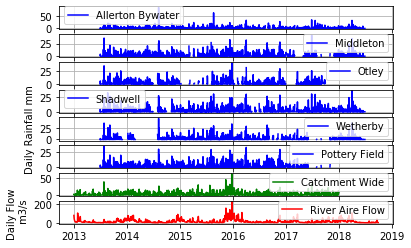

In [6]:
def format_fig(ax, param, label_text, color_val):
    ax.plot(df_data.index, df_data[param], label = label_text, color = color_val)
    ax.grid()
    ax.legend()
    return ax

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, sharex=True)
ax1 = format_fig(ax1, 'Qry_AllertonBywater_Daily.RAIN_mm_TOT', 'Allerton Bywater','b')
ax2 = format_fig(ax2, 'Qry_Middleton_Daily.RAIN_mm_TOT', 'Middleton','b')
ax3 = format_fig(ax3, 'Qry_Otley_Daily.RAIN_mm_TOT', 'Otley','b')
ax4 = format_fig(ax4, 'Qry_Shadwell_Daily.RAIN_mm_TOT', 'Shadwell','b')
ax5 = format_fig(ax5, 'Qry_Wetherby_Daily.RAIN_mm_TOT', 'Wetherby','b')
ax6 = format_fig(ax6, 'Qry_PotteryField_Daily.RAIN_mm_TOT', 'Pottery Field','b')
ax7 = format_fig(ax7, 'Rainfall', 'Catchment Wide','g')
ax8 = format_fig(ax8, 'Flow', 'River Aire Flow','r')

ax5.set_ylabel('Daily Rainfall mm')
ax8.set_ylabel('Daily Flow \n m3/s')
plt.show()

In [7]:
df_data = df_data.dropna()
df_data.describe()

Flow    Rainfall        index  \
count  600.000000  600.000000   600.000000   
mean    21.794850    3.310333   585.903333   
std     24.233718    5.871316   419.635342   
min      4.590000    0.000000     0.000000   
25%      7.412500    0.000000   149.750000   
50%     11.900000    0.900000   524.500000   
75%     26.875000    4.125000   886.250000   
max    228.000000   62.700000  1433.000000   

       Qry_AllertonBywater_Daily.RAIN_mm_TOT  Qry_Middleton_Daily.RAIN_mm_TOT  \
count                             600.000000                       600.000000   
mean                                2.342667                         2.589000   
std                                 5.736162                         4.791278   
min                                 0.000000                         0.000000   
25%                                 0.000000                         0.000000   
50%                                 0.200000                         0.400000   
75%                                 2.400000                         3.200000   
max                                83.199870                        36.000000   

       Qry_Otley_Daily.RAIN_mm_TOT  Qry_Shadwell_Daily.RAIN_mm_TOT  \
count                   600.000000                      600.000000   
mean                      2.740000                        2.541000   
std                       5.117088                        4.809304   
min                       0.000000                        0.000000   
25%                       0.000000                        0.000000   
50%                       0.400000                        0.400000   
75%                       3.200000                        3.000000   
max                      41.800090                       32.400000   

       Qry_Wetherby_Daily.RAIN_mm_TOT  Qry_PotteryField_Daily.RAIN_mm_TOT  
count                      600.000000                          600.000000  
mean                         2.565667                            2.448333  
std                          5.157459                            4.680226  
min                          0.000000                            0.000000  
25%                          0.000000                            0.000000  
50%                          0.200000                            0.200000  
75%                          3.000000                            3.000000  
max                         45.200100                           35.600000

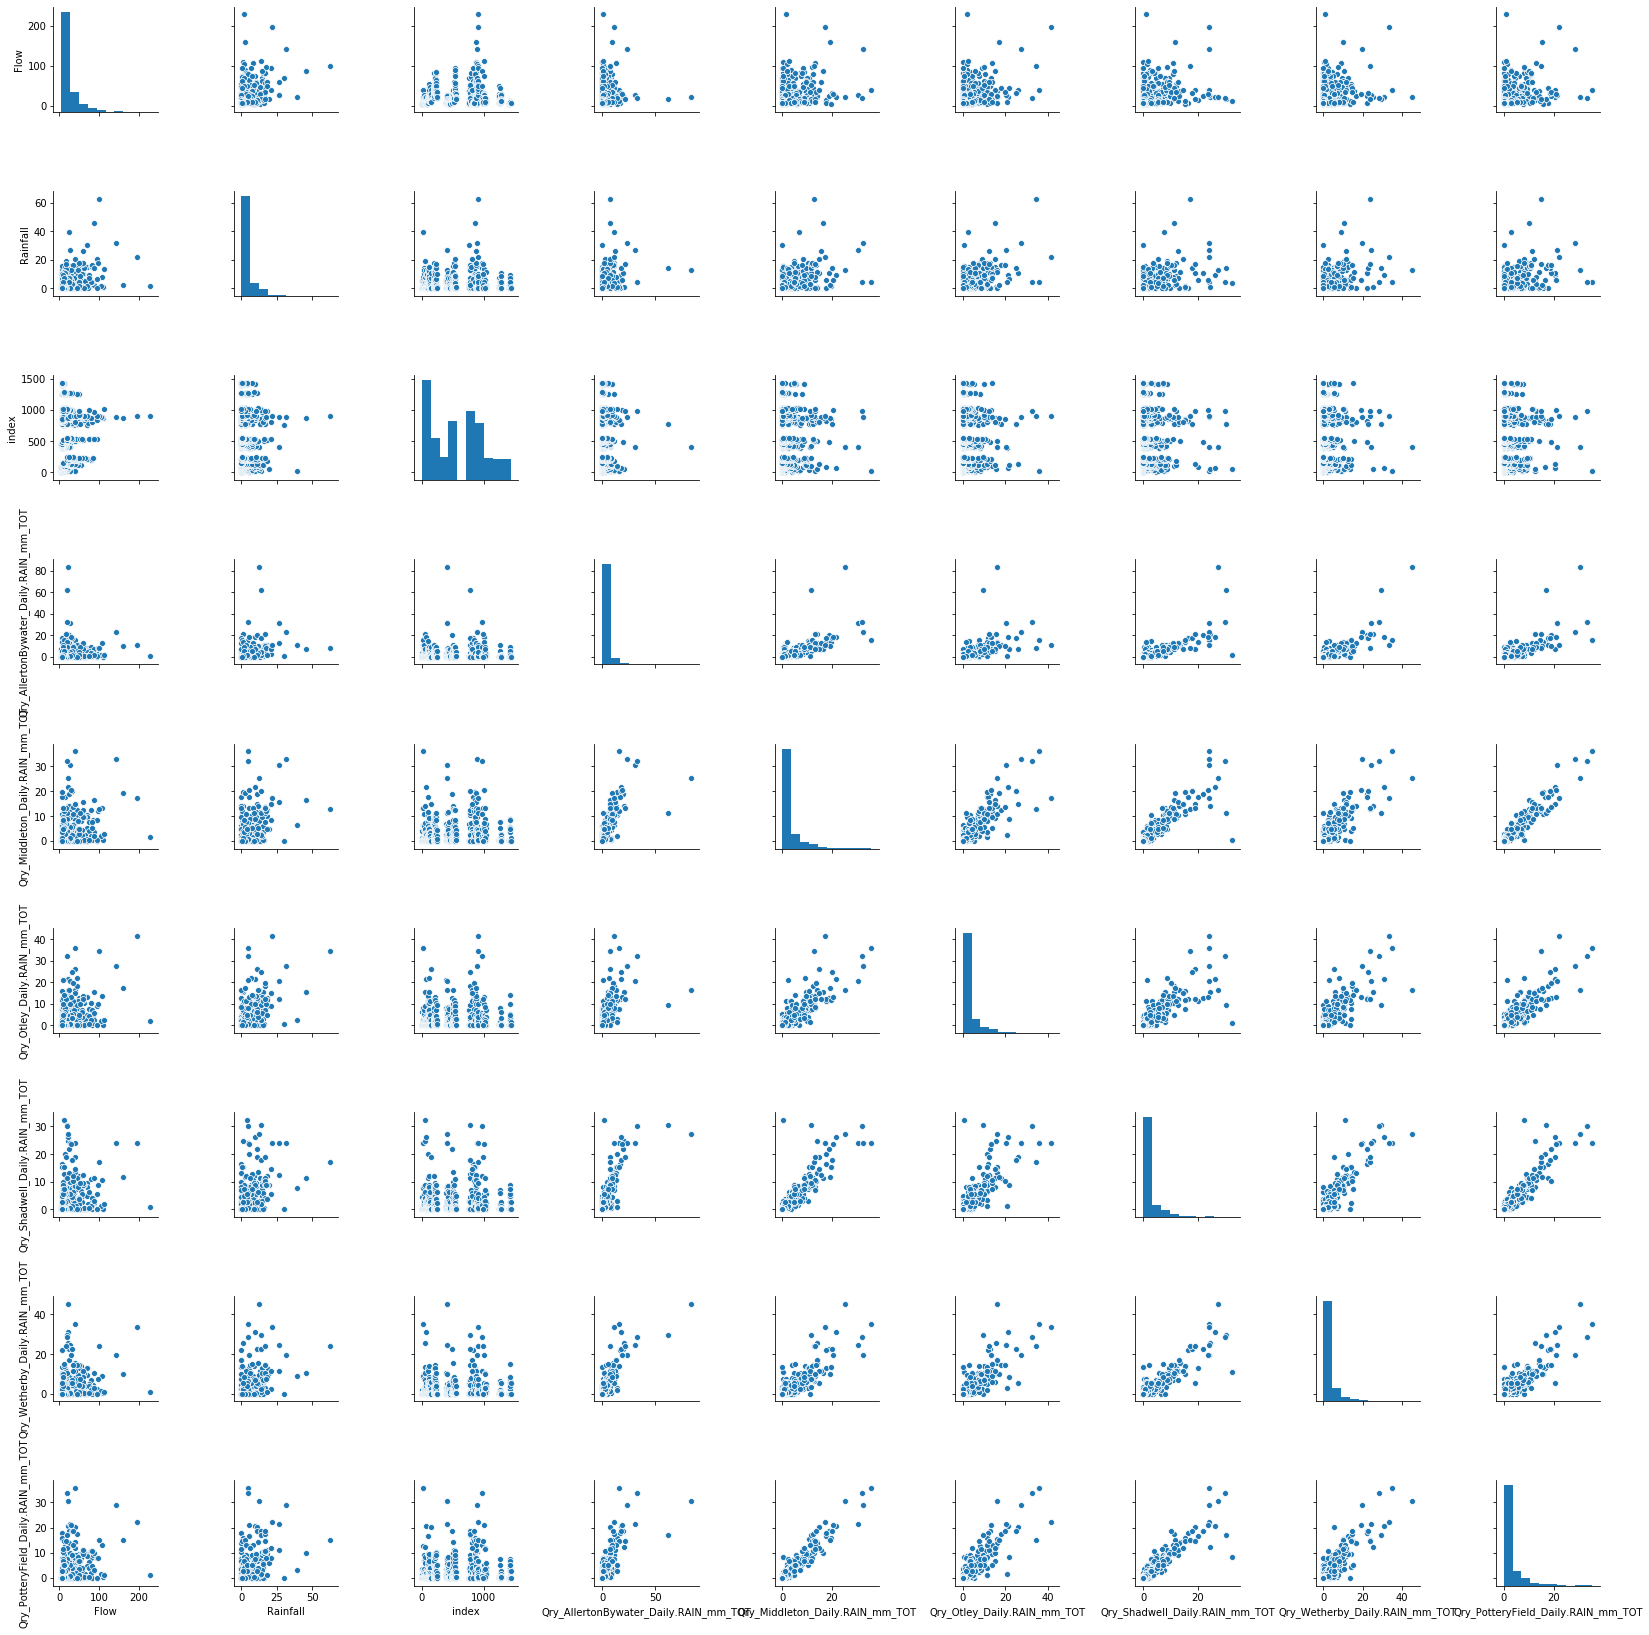

In [28]:
sns.pairplot(df_data)
plt.savefig(r'C:\Users\DAW85586\OneDrive - Mott MacDonald\Documents\MachineLearning\Projects\pairplot.png')

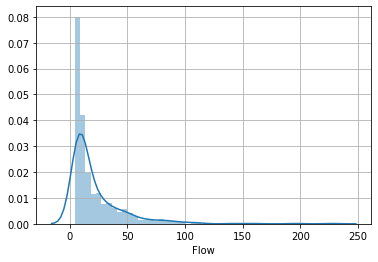

In [29]:
fig, (ax1) = plt.subplots(1)
sns.distplot(df_data['Flow'])
plt.grid()


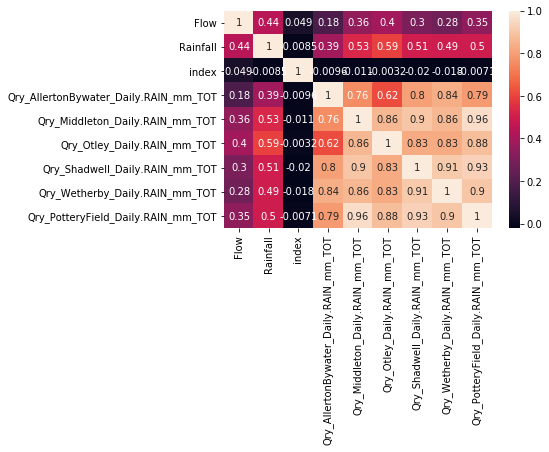

In [30]:
fig, (ax1) = plt.subplots(1)
sns.heatmap(df_data.corr(), annot = True)

In [31]:
df_data.columns

Index(['Flow', 'Rainfall', 'index', 'Qry_AllertonBywater_Daily.RAIN_mm_TOT',
       'Qry_Middleton_Daily.RAIN_mm_TOT', 'Qry_Otley_Daily.RAIN_mm_TOT',
       'Qry_Shadwell_Daily.RAIN_mm_TOT', 'Qry_Wetherby_Daily.RAIN_mm_TOT',
       'Qry_PotteryField_Daily.RAIN_mm_TOT'],
      dtype='object')

In [32]:
X = df_data[['Rainfall', 'Qry_AllertonBywater_Daily.RAIN_mm_TOT',
       'Qry_Middleton_Daily.RAIN_mm_TOT', 'Qry_Otley_Daily.RAIN_mm_TOT',
       'Qry_Shadwell_Daily.RAIN_mm_TOT', 'Qry_Wetherby_Daily.RAIN_mm_TOT',
       'Qry_PotteryField_Daily.RAIN_mm_TOT']]

In [33]:
y = df_data['Flow']

In [34]:
from sklearn.model_selection import train_test_split 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
lm = LinearRegression()

In [38]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
print(lm.intercept_)

13.932764320694655


In [40]:
lm.coef_

array([ 1.44731655, -1.7133464 ,  0.63098727,  0.65708033, -0.71957654,
       -0.7044112 ,  2.54355321])

In [41]:
X_train.columns

Index(['Rainfall', 'Qry_AllertonBywater_Daily.RAIN_mm_TOT',
       'Qry_Middleton_Daily.RAIN_mm_TOT', 'Qry_Otley_Daily.RAIN_mm_TOT',
       'Qry_Shadwell_Daily.RAIN_mm_TOT', 'Qry_Wetherby_Daily.RAIN_mm_TOT',
       'Qry_PotteryField_Daily.RAIN_mm_TOT'],
      dtype='object')

In [42]:
cdf = pd.DataFrame(lm.coef_, X.columns, columns = ['Coeff'])

In [43]:
cdf

Coeff
Rainfall                               1.447317
Qry_AllertonBywater_Daily.RAIN_mm_TOT -1.713346
Qry_Middleton_Daily.RAIN_mm_TOT        0.630987
Qry_Otley_Daily.RAIN_mm_TOT            0.657080
Qry_Shadwell_Daily.RAIN_mm_TOT        -0.719577
Qry_Wetherby_Daily.RAIN_mm_TOT        -0.704411
Qry_PotteryField_Daily.RAIN_mm_TOT     2.543553

In [44]:
predictions = lm.predict(X_test)

In [45]:
predictions

array([ 19.14392026,  23.35494923,  12.72405068,  13.59009504,
        14.07749598,  19.91719019,  13.93276432,  13.93276432,
        14.2482031 ,  14.86816885,  14.93864239,  54.60623163,
         9.00344151,  14.83207177,  14.66771328,  22.0040809 ,
        14.07749598,  12.66921202,  18.30969239,  14.07749598,
        12.65707974,  12.74615639,  13.93276432,  16.39705188,
        13.08882567,  24.50284091,  20.70947865,  57.4171554 ,
        20.01942688,  17.32863572,  13.93276432,  13.93358067,
        16.70830773,  16.18623809,  12.48961756,  19.17972812,
        18.06731018, -57.43250577,  20.89562739,  13.91504647,
        19.61621674,  14.12146039,  16.99973213,  13.93276432,
        26.52926281,  26.30111723,  13.93276432,  20.03516618,
        15.81427584,  13.93276432,  13.41641202,  14.05416136,
        19.60317107,  20.18538614,  14.44147496,  15.2375152 ,
        23.48505357,   1.90734432,  14.07749598,  15.49191798,
        14.97717061,  30.33340361,  21.87833498,  32.21

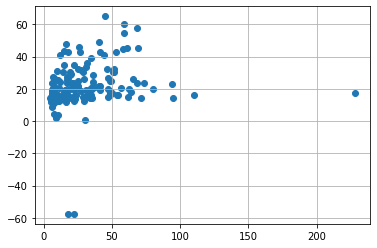

In [46]:
# I was hoping this was going to be fairly linear 
fig, (ax1) = plt.subplots(1)
plt.scatter(y_test, predictions)
plt.grid()

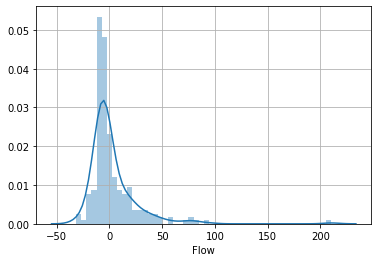

In [47]:
fig, (ax1) = plt.subplots(1)
sns.distplot((y_test-predictions))
plt.grid()

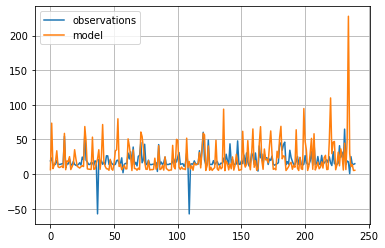

In [48]:
fig, (ax1) = plt.subplots(1)
plt.plot(predictions, label = 'observations')
plt.plot(y_test.values, label = 'model')
plt.legend()
plt.grid()

# 2. Linear regression

A look at the accuray of the linear regression with using just the catchment wide rainfall

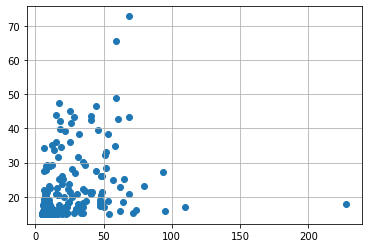

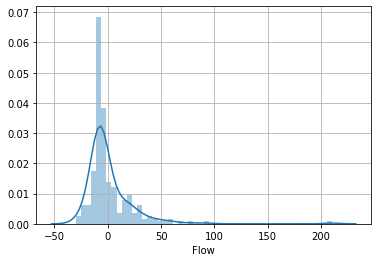

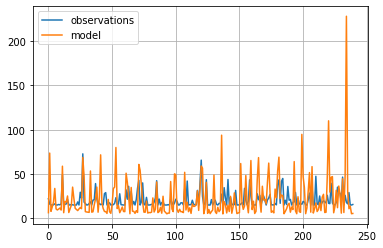

In [49]:
X = df_data[['Rainfall']]

y = df_data['Flow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

# I was hoping this was going to be fairly linear 
fig, (ax1) = plt.subplots(1)
plt.scatter(y_test, predictions)
plt.grid()

fig, (ax1) = plt.subplots(1)
sns.distplot((y_test-predictions))
plt.grid()

fig, (ax1) = plt.subplots(1)
plt.plot(predictions, label = 'observations')
plt.plot(y_test.values, label = 'model')
plt.legend()
plt.grid()

# 3. Linear regression - Account for lag

As mentioned at the beginning of the notebook there is always going to be a lag between the rainfall and the river flow. Also the amount  of time the duration of rainfall will impact the flow. For the next step Ill try and account for this by including the average rainfall of the past 5 days in the regression model.

C:\Users\DAW85586\Anaconda3\envs\geoPython3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\DAW85586\Anaconda3\envs\geoPython3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\DAW85586\Anaconda3\envs\geoPython3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\DAW85586\Anaconda3\envs\geoPython3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

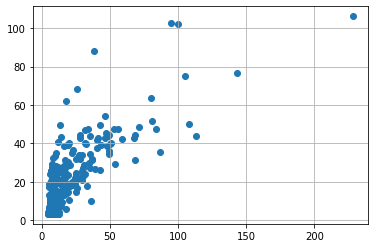

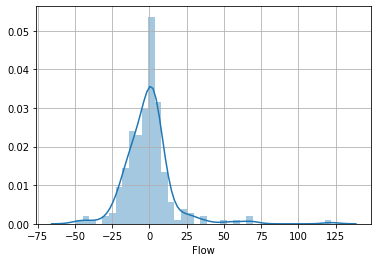

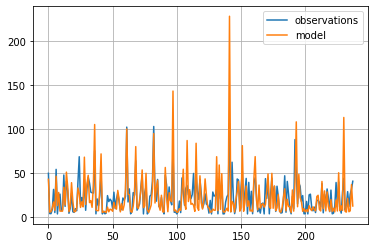

In [50]:
five_day_average = []
for ind, i in enumerate(df_data['Rainfall'].values):
    five_day_average.append(np.mean(df_data['Rainfall'].values[ind-5:ind]))
X = df_data[['Rainfall']]
X['five_day_average'] = five_day_average
X.dropna(inplace = True)

y = df_data['Flow']
y = y.iloc[4:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

# I was hoping this was going to be fairly linear 
fig, (ax1) = plt.subplots(1)
plt.scatter(y_test, predictions)
plt.grid()

fig, (ax1) = plt.subplots(1)
sns.distplot((y_test-predictions))
plt.grid()

fig, (ax1) = plt.subplots(1)
plt.plot(predictions, label = 'observations')
plt.plot(y_test.values, label = 'model')
plt.legend()
plt.grid()